In [221]:
import os
import random
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

In [222]:
#HYPERPARAMETERS

epochs = 10
batch_size = 8
margin = 1 # margin for contrastive loss

# Creating paths to appropriate images

In [223]:
class ContrastiveGenerator:
    def __init__(self, datasetPath, number_of_pairs):       #number_of_pairs : number of iterations in loop next_get_item()
        # empty list that will contain the subdirectory names of products
        # of the dataset directory with more than one image in it
        self.types_of_products = self.read_types_of_products(datasetPath)
        self.number_of_pairs = number_of_pairs
        # create a dictionary of people name to their image names
        self.allProducts = self.generate_all_products_dict()
        
    # The function below works correctly in 3 cases:
    # 1) images are only in subfolders 
    # 2) images are only in subsubfolders
    # 3) images are both in subfolders and subsubfolders
    def read_types_of_products(self, datasetPath) -> list[str]:
        # subdirectories in the main directory
        types = []
        subdirs_main = [d for d in os.listdir(datasetPath) if os.path.isdir(os.path.join(datasetPath,d))]
        #iterate over subdirectories in the main directory:
        for folderName in subdirs_main:
            subdirs_main_path = os.path.join(datasetPath, folderName)
            # subsubdirectories 
            subdirs = [d for d in os.listdir(subdirs_main_path) if os.path.isdir(os.path.join(subdirs_main_path,d))]
            # if there are no subsubdirectories, add the subdirectory name 
            if len(subdirs) == 0:
                types.append(subdirs_main_path)
            else:
                #traverse through all subsubdirectories and add them
                for directory in subdirs:
                    types.append(os.path.join(subdirs_main_path,directory)) 
        return types
            # # lub to co poniżej : jeśli jest folder bez podfolderów
            # absoluteFolderName = os.path.join(datasetPath, folderName) #datasetPath + "/" + folderName
            # # get the number of images in the subdirectory
            # numImages = len(os.listdir(absoluteFolderName))
            # if numImages > 1:
            #     self.types_of_products.append(absoluteFolderName)


    # Buildings paths to specific images
    def generate_all_products_dict(self):
        # all_products = dict()
        # for product in self.types_of_products:
        #     if os.path.isdir(product):  # Sprawdź, czy to katalog
        #         image_names = os.listdir(product)
        #         product_photos = [os.path.join(product, imageName) for imageName in image_names]
        #         all_products[product] = product_photos
        # return all_products
        
        # create an empty dictionary that will be populated with
        # directory names as keys and image names as values
        all_products = dict()
        for product in self.types_of_products:
            image_names = os.listdir(product)
            # build the image paths and populate the dictionary
            productsPhotos = [os.path.join(product, imageName) for imageName in image_names]
            all_products[product] = productsPhotos
        print(len(all_products))
        return all_products

    def get_next_element(self):
        for i in range(self.number_of_pairs):
            anchor = random.choice(self.types_of_products)

            # copy the list of products
            temporaryImages = self.types_of_products.copy()
            temporaryImages.remove(anchor)

            # random product from a list of products without anchor
            negativeProduct = random.choice(temporaryImages)

            (anchorProduct, positiveProduct) = np.random.choice(
                a=self.allProducts[anchor],
                size=2,
                replace=False
            )
            # Image from the negative folder
            negativeProduct = random.choice(self.allProducts[negativeProduct])


            yield (anchorProduct, positiveProduct, 0.0)
            yield (anchorProduct, negativeProduct, 1.0)

# Create object for creating dataset

In [224]:
# path = r"/home/c100rczyk/VSCode/InsERT/Fruits"
# path = r"C:\Users\matim\Documents\Fruits360\archive\fruits-360_dataset\fruits-360\Training"
path = r"C:\Users\matim\Documents\FruitDataset\archive"
number_of_samples = 32
generator = ContrastiveGenerator(path, number_of_samples)

27


# Generator for creating dataset

In [225]:
dataset = tf.data.Dataset.from_generator( generator.get_next_element,
                                          output_signature=(tf.TensorSpec(shape=(), dtype=tf.string),
                                                            tf.TensorSpec(shape=(), dtype=tf.string),
                                                            tf.TensorSpec(shape=(), dtype=tf.float32)))

In [226]:
print(dataset)

<_FlatMapDataset element_spec=(TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.string, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>


# Creating dataset


In [227]:
IMAGE_SIZE = (258, 320)



def decode_and_resize(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, IMAGE_SIZE)
    img = tf.image.convert_image_dtype(img, tf.float32)
    return img

def decode_resize_wrapper(image_path1, image_path2,value):
    # return tf.py_function(decode_and_resize, [image_path], tf.float32)
    img1 = decode_and_resize(image_path1)
    img2 = decode_and_resize(image_path2)
    return ((img1, img2), value)

def generate_new_pack_of_images():
    
    # Mapowanie funkcji na oba obrazy
    img_pack = dataset.map(lambda image_path1, image_path2, value: (decode_resize_wrapper(image_path1,image_path2,value)) )
    img_pack = img_pack.batch(batch_size)
    
    # print(list(img_pack))
    return img_pack

    # list_of_products = []
    
    # for (img1, img2), value in img_pack:
    #     list_of_products.append( (img1, img2,value  ))    #value.numpy()
        
    # return list_of_products




# Create new pack of images and labels

In [228]:
touple_of_products = generate_new_pack_of_images()
print(touple_of_products)

<_BatchDataset element_spec=((TensorSpec(shape=(None, 258, 320, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 258, 320, 3), dtype=tf.float32, name=None)), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>


## show and check if everything is ok ( how to get image from BatchDataset?? )

8


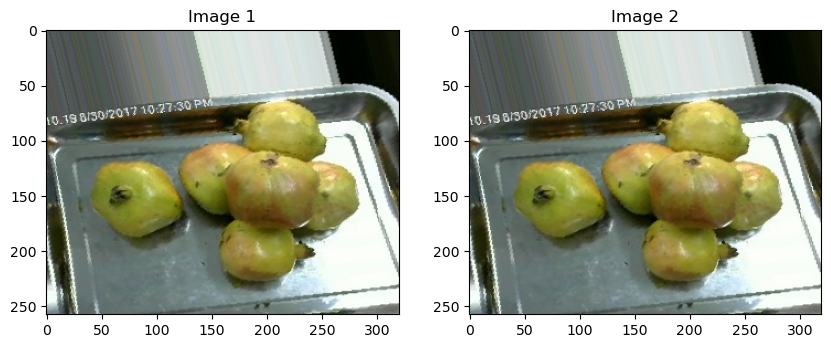

Etykieta: tf.Tensor([0. 1. 0. 1. 0. 1. 0. 1.], shape=(8,), dtype=float32)
8


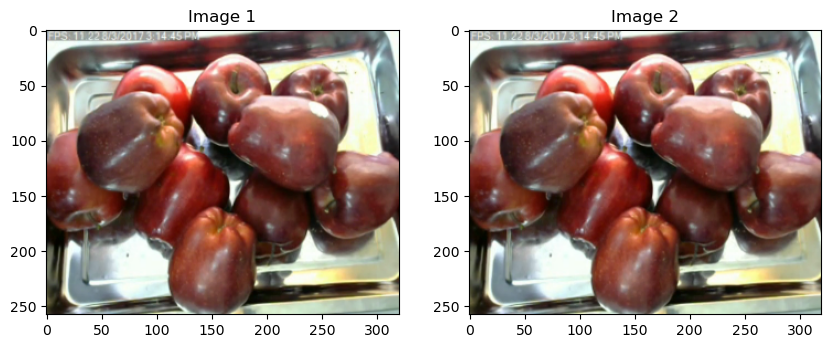

Etykieta: tf.Tensor([0. 1. 0. 1. 0. 1. 0. 1.], shape=(8,), dtype=float32)
8


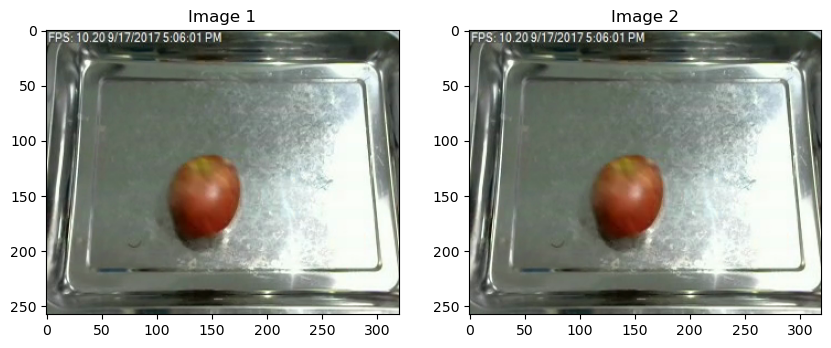

Etykieta: tf.Tensor([0. 1. 0. 1. 0. 1. 0. 1.], shape=(8,), dtype=float32)
8


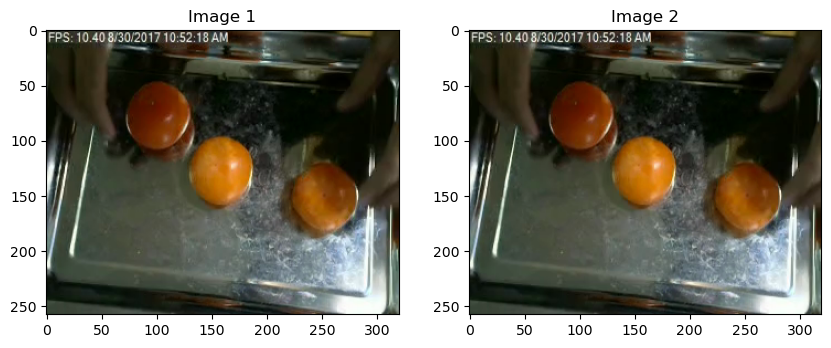

Etykieta: tf.Tensor([0. 1. 0. 1. 0. 1. 0. 1.], shape=(8,), dtype=float32)
8


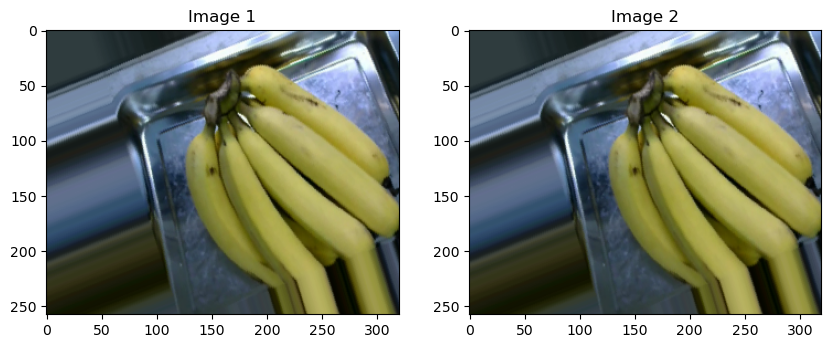

Etykieta: tf.Tensor([0. 1. 0. 1. 0. 1. 0. 1.], shape=(8,), dtype=float32)
8


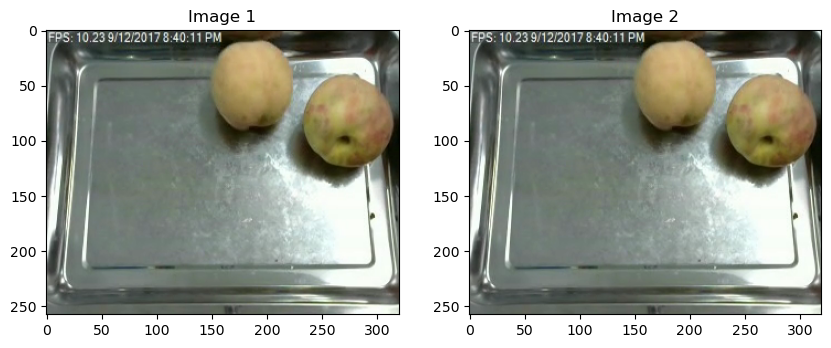

Etykieta: tf.Tensor([0. 1. 0. 1. 0. 1. 0. 1.], shape=(8,), dtype=float32)
8


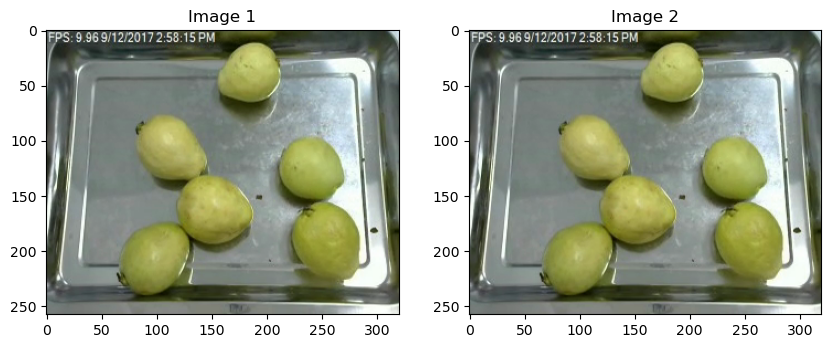

Etykieta: tf.Tensor([0. 1. 0. 1. 0. 1. 0. 1.], shape=(8,), dtype=float32)
8


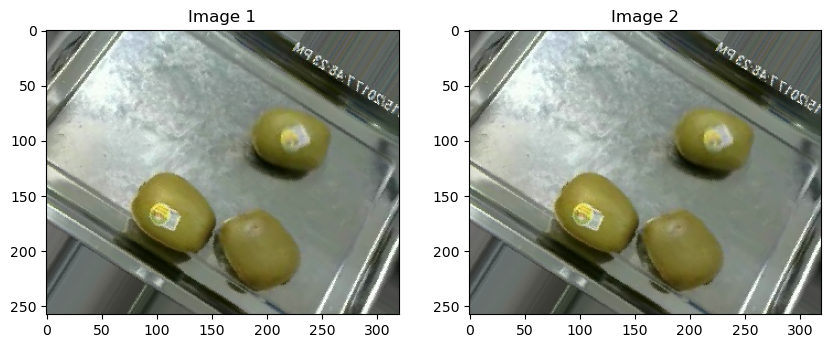

Etykieta: tf.Tensor([0. 1. 0. 1. 0. 1. 0. 1.], shape=(8,), dtype=float32)


In [229]:
# wyświetlenie obrazów:
import numpy
from keras import ops
for img1, label in touple_of_products:
    
    plt.figure(figsize=(10, 5))
    # Obraz 1
    plt.subplot(1, 2, 1)
    print(len(img1[0]))
    plt.imshow(np.asarray(img1[0][1]).astype('uint8'))
        
    plt.title('Image 1')
    # Obraz 2
    plt.subplot(1, 2, 2)
    plt.imshow(np.asarray(img1[0][1]).astype('uint8'))
    plt.title('Image 2')
    plt.show()
    print("Etykieta:", label)

In [230]:
# img1, img2, label = list_of_products[1]

# # Wyświetlenie obrazów
# plt.figure(figsize=(10, 5))
# # Obraz 1
# plt.subplot(1, 2, 1)
# plt.imshow(img1)
# plt.title('Image 1')
# # Obraz 2
# plt.subplot(1, 2, 2)
# plt.imshow(img2)
# plt.title('Image 2')

# plt.show()
# print("Etykieta:", label)

# Model for learn products distinguish

In [231]:
import keras

def euclidean_distance(vects):
    """
    Znalezienie odległości euklidesowej pomiędzy dwoma wektorami:

    Arguments:
        vects: Lista zawierające dwa tensory tej samej długości

    Returns:
        Tensor containing euclidean distance pomiędzy podanymi wektorami
    """
    x, y = vects

    sum_square = tf.reduce_sum(tf.square(x-y), axis=1, keepdims=True)   
    return tf.sqrt(tf.maximum(sum_square, keras.backend.epsilon()))

input = keras.layers.Input((258,320,3))
x = keras.layers.BatchNormalization()(input)
x = keras.layers.Conv2D(16, (5,5), activation="tanh")(x)  # ilość elementów filtra, rozmiar filtra
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Conv2D(32, (5,5), activation="tanh")(x)
x = keras.layers.AveragePooling2D(pool_size=(2,2))(x)
x = keras.layers.Flatten()(x)

x = keras.layers.BatchNormalization()(x)
x = keras.layers.Dense(10, activation="tanh")(x)
embedding_network = keras.Model(input, x)   # tworzę instancję modelu. Model nazywam embedding network
                                            # używam tego do dalszego definiowania modelu

input_1 = keras.layers.Input((258,320,3))
input_2 = keras.layers.Input((258,320,3))

tower_1 = embedding_network(input_1)
tower_2 = embedding_network(input_2)

merge_layer = keras.layers.Lambda(euclidean_distance, output_shape=(1,))([tower_1, tower_2])

normal_layer = keras.layers.BatchNormalization()(merge_layer)
output_layer = keras.layers.Dense(1, activation="sigmoid")(normal_layer)

siamese = keras.Model(inputs=[input_1, input_2], outputs=output_layer)

# Definition of loss function

In [232]:
def loss(margin=1):
    """
    Arguments: 
        margin: Integer, defines the baseline for distance for which pairs
        shoud be classified as dissimilar "1"
    Returns:
        tensor with contrastive loss as floating point value
    """
    # 0-same ,  1-different
    
    #contrastive_loss = (1-y_true)*

    def contrastive_loss(y_true, y_pred):
        """Calculate the contrastive loss
        Arguments:
            y_true: List of labels, each label is of type "float32"
            y_pred: List of predictions
            y_pred to przewidywane odległości między parami danych, które model stara się nauczyć
        Returns:
            A tensor containing contrastive loss value (folat)
        """
        square_pred = tf.square(y_pred)
        margin_square = tf.square(tf.maximum(margin - (y_pred), 0))
        return tf.reduce_mean((1 - y_true) * square_pred + (y_true) * margin_square)
    return contrastive_loss
    

## Compile model with contrastive loss


In [233]:
# Kompilacja modelu z contrastive_loss

siamese.compile(loss=loss(margin=margin), optimizer="RMSprop", metrics=["accuracy"])
siamese.summary()

Model: "functional_19"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_13      │ (None, 258, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_14      │ (None, 258, 320,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ functional_17       │ (None, 10)        │  2,118,326 │ input_layer_13[0… │
│ (Functional)        │                   │            │ input_layer_14[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda_4 (Lambda)   │ (None, 1)         │          0 │ functional_17[0]… │
│                     │                   │            │ functional_17[1]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1)         │          4 │ lambda_4[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_9 (Dense)     │ (None, 1)         │          2 │ batch_normalizat… │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,118,332 (8.08 MB)

 Trainable params: 1,817,716 (6.93 MB)

 Non-trainable params: 300,616 (1.15 MB)

In [234]:
#train_products_list = touple_of_products[:(int)(0.8*2*number_of_samples)]
#val_products_list = touple_of_products[(int)(0.8*2*number_of_samples) :]

siamese.fit( touple_of_products, 
            #validation_split= imagesyy, 
            batch_size = batch_size,
            epochs = epochs
            )

Epoch 1/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 5s 329ms/step - accuracy: 0.4812 - loss: 0.2609
Epoch 2/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 335ms/step - accuracy: 0.3433 - loss: 0.2686
Epoch 3/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 334ms/step - accuracy: 0.4822 - loss: 0.2510
Epoch 4/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 326ms/step - accuracy: 0.3793 - loss: 0.2679
Epoch 5/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 331ms/step - accuracy: 0.3876 - loss: 0.2602
Epoch 6/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 350ms/step - accuracy: 0.5259 - loss: 0.2381
Epoch 7/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step - accuracy: 0.4546 - loss: 0.2602
Epoch 8/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 360ms/step - accuracy: 0.4486 - loss: 0.2533
Epoch 9/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 367ms/step - accuracy: 0.3982 - loss: 0.2616
Epoch 10/10
8/8 ━━━━━━━━━━━━━━━━━━━━ 3s 364ms/step - accuracy: 0.5443 - loss: 0.2451


# Archiwum

In [235]:
# print(len(train_products_list))
# print(len(val_products_list))

# x_train_1 = []
# x_train_2 = []
# labels_train = []
# x_val_1 = []
# x_val_2 = []
# labels_val = []
# for (img1, img2), label in train_products_list:
#     x_train_1.append(img1)
#     x_train_2.append(img2)
#     labels_train.append(label)
# for (img1, img2), label in val_products_list:
#     x_val_1.append(img1)
#     x_val_2.append(img2)
#     labels_val.append(label)


# print(x_train_1)
# print(labels_train)